In [1]:
import pandas as pd
import numpy as np

### 1. Data Collection

In [3]:
# Import and read the dataset

df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding='latin1')
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# We have a total of 1.6 million records so it is a large dataset

df.shape

(1600000, 6)

In [5]:
# Replace label 4 with 1
df[0] = df[0].replace(4, 1)

In [6]:
# Randomly selecting 50,000 rows because 1.6 million rows will take huge amount of time to get trained

df_sample = df.sample(n=50000, random_state=42).reset_index(drop=True)

In [7]:
df_sample.shape

(50000, 6)

### 2. Data Preprocessing

In [9]:
# Renaming columns

df_sample.columns = ['label', 'b1', 'b2', 'b3', 'b4', 'text']

In [10]:
df_sample.head()

,label,b1,b2,b3,b4,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [11]:
# Remove unnecessary columns

df_sample = df_sample.drop(columns=['b1','b2','b3','b4'])
df_sample.head()

,label,text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem


In [12]:
# Check missing values

df_sample.isnull().sum()

label    0
text     0
dtype: int64

In [13]:
# Import Libraries

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

#### * Clean the text

In [15]:
# Initialize Lemmatizer

wordnet = WordNetLemmatizer()

In [16]:
len(df_sample)

50000

In [52]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MyPc\AppData\Roaming\nltk_data...


True

In [54]:
# Remove special characters
# Lowercase all the words
# Apply Lemmatization

corpus=[]
for i in range(0,len(df_sample)):
    review = re.sub('[^a-zA-z]',' ',df_sample['text'][i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

### 3. Train Test Split

In [57]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['label'], test_size=0.2, random_state=42)

### 4. Vectorization
**We will use these techniques** :-
* Bag of Words (BOW)
* TF-IDF
* Word2Vec

#### Bag of Words

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
vectorizer = CountVectorizer(max_features=5000)

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(X_train)

# Transform the test data (DO NOT fit on test data)
X_test_bow = vectorizer.transform(X_test)

#### TF-IDF

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data (DO NOT fit on test data)
X_test_tfidf = tfidf.transform(X_test)

#### Word2Vec and AvgWord2Vec

In [66]:
from gensim.models import Word2Vec

# Train Word2Vec on the entire dataset
sentences = [text.split() for text in df_sample['text']]
word2vec_model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4)

# Average Word2Vec for training and test sets
def avg_word2vec(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(vectors) > 0:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 100  # Return a zero vector if no words are found

# Apply to training and test sets
X_train_w2v = X_train.apply(avg_word2vec)
X_test_w2v = X_test.apply(avg_word2vec)

# Convert to numpy arrays
X_train_w2v = np.array(X_train_w2v.tolist())
X_test_w2v = np.array(X_test_w2v.tolist())

In [69]:
X_train_w2v

array([[ 0.21659465, -0.19658713, -0.11137953, ...,  0.1918255 ,
         0.3639431 ,  0.11338262],
       [ 0.2967877 , -0.40661436, -0.318751  , ...,  0.51672125,
         1.2735051 ,  0.7962029 ],
       [ 0.41808406, -0.3601326 , -0.48380318, ...,  0.54981387,
         1.110573  ,  0.8854276 ],
       ...,
       [ 0.09499938, -0.23474433, -0.13380143, ...,  0.27602392,
         1.2437433 ,  0.6044442 ],
       [ 0.37798306, -0.47170335, -0.5614938 , ...,  0.47770655,
         1.3711845 ,  0.77225435],
       [ 0.24479859, -0.23066503, -0.22248322, ...,  0.27129108,
         1.2339598 ,  0.51944983]], dtype=float32)

In [71]:
X_test_w2v

array([[ 1.8631093e-01, -2.0180625e-01, -2.7438819e-01, ...,
         3.2294348e-01,  1.3818318e+00,  7.3958921e-01],
       [-5.2238744e-02, -3.8300800e-01, -5.6255430e-01, ...,
         6.0702050e-01,  2.0552208e+00,  7.7515471e-01],
       [ 5.2469775e-02, -4.0717613e-02, -2.7008716e-04, ...,
         3.9456166e-02,  6.9487773e-02,  3.5417847e-02],
       ...,
       [ 6.4932501e-01, -2.4719280e-01, -2.6621988e-01, ...,
         5.3241092e-01,  1.1297841e+00,  9.0461421e-01],
       [-6.6506542e-02, -2.1279223e-01, -3.4821808e-01, ...,
         4.3317413e-01,  2.1042113e+00,  8.5187972e-01],
       [ 3.4519047e-01, -3.5478234e-01, -2.8823361e-01, ...,
         2.3909190e-01,  6.2278193e-01,  2.7351189e-01]], dtype=float32)

### 5. Feature Scaling

In [74]:
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

In [76]:
# Scaling for SVC on BoW & TF-IDF (MaxAbsScaler for sparse matrices)
scaler_bow = MaxAbsScaler()
X_train_bow_scaled = scaler_bow.fit_transform(X_train_bow)
X_test_bow_scaled = scaler_bow.transform(X_test_bow)

scaler_tfidf = MaxAbsScaler()
X_train_tfidf_scaled = scaler_tfidf.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler_tfidf.transform(X_test_tfidf)

# Scaling for Logistic Regression & SVC on Word2Vec (StandardScaler for dense vectors)
scaler_w2v = StandardScaler()
X_train_w2v_scaled = scaler_w2v.fit_transform(X_train_w2v)
X_test_w2v_scaled = scaler_w2v.transform(X_test_w2v)

### 6. Model Training (ML)
**We will use** :-
* Logistic Regression
* SVM
* Random Forest

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

#### Train Models on BoW Features

In [82]:
# Logistic Regression on BoW (No scaling needed)
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)
y_pred_lr_bow = lr_bow.predict(X_test_bow)

# SVM on BoW (Uses scaled BoW)
svm_bow = SVC()
svm_bow.fit(X_train_bow_scaled, y_train)
y_pred_svm_bow = svm_bow.predict(X_test_bow_scaled)

# Random Forest on BoW (No scaling needed)
rf_bow = RandomForestClassifier()
rf_bow.fit(X_train_bow, y_train)
y_pred_rf_bow = rf_bow.predict(X_test_bow)

C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Train Models on TF-IDF Features

In [84]:
# Logistic Regression on TF-IDF (No scaling needed)
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

# SVM on TF-IDF (Uses scaled TF-IDF)
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf_scaled, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf_scaled)

# Random Forest on TF-IDF (No scaling needed)
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)

C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Train Models on Word2Vec Features

In [86]:
# Logistic Regression on Word2Vec (Uses scaled Word2Vec)
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v_scaled, y_train)
y_pred_lr_w2v = lr_w2v.predict(X_test_w2v_scaled)

# SVM on Word2Vec (Uses scaled Word2Vec)
svm_w2v = SVC()
svm_w2v.fit(X_train_w2v_scaled, y_train)
y_pred_svm_w2v = svm_w2v.predict(X_test_w2v_scaled)

# Random Forest on Word2Vec (No scaling needed)
rf_w2v = RandomForestClassifier()
rf_w2v.fit(X_train_w2v, y_train)
y_pred_rf_w2v = rf_w2v.predict(X_test_w2v)

### 6. Evaluate all the Models

In [88]:
# Function to evaluate models

def evaluate_model(y_true, y_pred, model_name, vector_name):
    print(f"Results for {model_name} on {vector_name} features:")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\n" + "="*50 + "\n")

In [89]:
# Evaluate BoW models
evaluate_model(y_test, y_pred_lr_bow, "Logistic Regression", "BoW")
evaluate_model(y_test, y_pred_svm_bow, "SVM", "BoW")
evaluate_model(y_test, y_pred_rf_bow, "Random Forest", "BoW")

# Evaluate TF-IDF models
evaluate_model(y_test, y_pred_lr_tfidf, "Logistic Regression", "TF-IDF")
evaluate_model(y_test, y_pred_svm_tfidf, "SVM", "TF-IDF")
evaluate_model(y_test, y_pred_rf_tfidf, "Random Forest", "TF-IDF")

# Evaluate Word2Vec models
evaluate_model(y_test, y_pred_lr_w2v, "Logistic Regression", "Word2Vec")
evaluate_model(y_test, y_pred_svm_w2v, "SVM", "Word2Vec")
evaluate_model(y_test, y_pred_rf_w2v, "Random Forest", "Word2Vec")

Results for Logistic Regression on BoW features:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      4977
           1       0.76      0.78      0.77      5023

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Accuracy: 0.7644


Results for SVM on BoW features:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      4977
           1       0.78      0.77      0.77      5023

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy: 0.7706


Results for Random Forest on BoW features:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4977
           1       0.77      0.73      0.75      5023

    accuracy       

#### Summary Table

In [91]:
import pandas as pd

# Create a list of results
results = [
    {"Model": "Logistic Regression", "Vector": "BoW", "Accuracy": accuracy_score(y_test, y_pred_lr_bow)},
    {"Model": "SVM", "Vector": "BoW", "Accuracy": accuracy_score(y_test, y_pred_svm_bow)},
    {"Model": "Random Forest", "Vector": "BoW", "Accuracy": accuracy_score(y_test, y_pred_rf_bow)},
    {"Model": "Logistic Regression", "Vector": "TF-IDF", "Accuracy": accuracy_score(y_test, y_pred_lr_tfidf)},
    {"Model": "SVM", "Vector": "TF-IDF", "Accuracy": accuracy_score(y_test, y_pred_svm_tfidf)},
    {"Model": "Random Forest", "Vector": "TF-IDF", "Accuracy": accuracy_score(y_test, y_pred_rf_tfidf)},
    {"Model": "Logistic Regression", "Vector": "Word2Vec", "Accuracy": accuracy_score(y_test, y_pred_lr_w2v)},
    {"Model": "SVM", "Vector": "Word2Vec", "Accuracy": accuracy_score(y_test, y_pred_svm_w2v)},
    {"Model": "Random Forest", "Vector": "Word2Vec", "Accuracy": accuracy_score(y_test, y_pred_rf_w2v)},
]

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model    Vector  Accuracy
3  Logistic Regression    TF-IDF    0.7713
4                  SVM    TF-IDF    0.7708
1                  SVM       BoW    0.7706
0  Logistic Regression       BoW    0.7644
2        Random Forest       BoW    0.7534
5        Random Forest    TF-IDF    0.7517
6  Logistic Regression  Word2Vec    0.6762
7                  SVM  Word2Vec    0.6665
8        Random Forest  Word2Vec    0.6459


In [100]:
import matplotlib, numpy
print(f"Matplotlib: {matplotlib.__version__}")  # Should be 3.4.3
print(f"NumPy: {numpy.__version__}")  # Should be 1.19.2

Matplotlib: 3.4.3
NumPy: 1.21.5


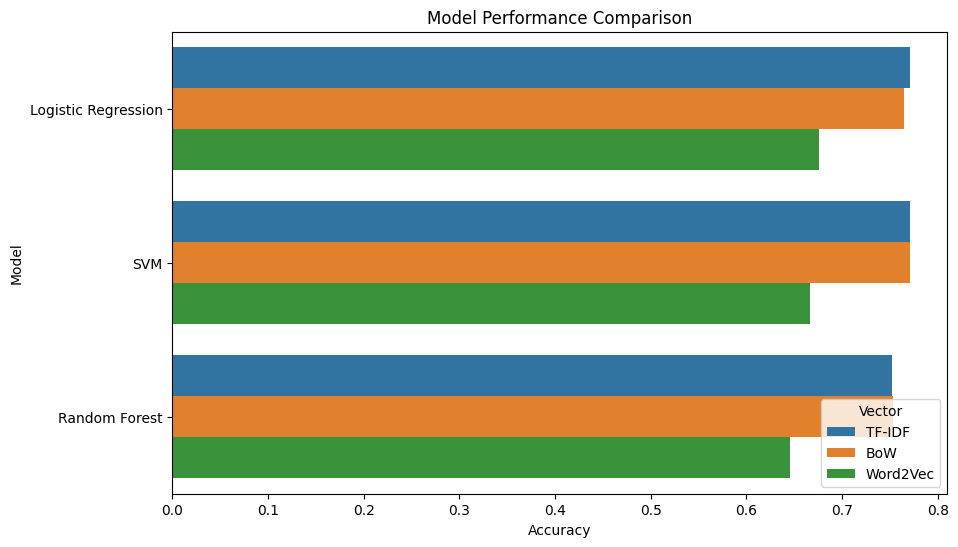

In [98]:
# Visualize the results

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", hue="Vector", data=results_df,orient='h')
plt.title("Model Performance Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.legend(title="Vector")
plt.show()

## Conclusion

### Best Performing Models
- **TF-IDF + Logistic Regression** achieved the highest accuracy (77.13%), followed closely by **TF-IDF + SVM** at 77.08%, making them the best-performing models.
- **BoW + SVM** (77.06%) is also a strong contender, showing that BoW features remain competitive.

### Key Observations
- **Random Forest** performs consistently lower on sparse features (TF-IDF: 75.17%, BoW: 75.34%), suggesting it's not as effective as Logistic Regression and SVM on these representations.
- **Word2Vec** (Avg. embeddings) performs the worst, with Logistic Regression at 67.62% and Random Forest at 64.59%, indicating that Word2Vec lacks sufficient semantic information for this task.

### Recommendation
- Use **TF-IDF + SVM** or **Logistic Regression** for the best results.
- If opting for **Word2Vec**, consider exploring pre-trained embeddings (e.g., **BERT**) or fine-tuning to improve performance.


# Let's use BERT model now

In [102]:
# We'll use the transformers library to tokenize the text data.
from transformers import AutoTokenizer

C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [104]:
# This cell was giving error of compatabilities so we have used Pytorch

'''tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
encoded_data = tokenizer(
    df_sample['text'].tolist(),  # Convert pandas Series to list
    max_length=128,  # Truncate or pad to this length
    padding='max_length',  # Pad to max_length
    truncation=True,  # Truncate longer sequences
    return_tensors='tf'  # Return TensorFlow tensors
)'''

"tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')\nencoded_data = tokenizer(\n    df_sample['text'].tolist(),  # Convert pandas Series to list\n    max_length=128,  # Truncate or pad to this length\n    padding='max_length',  # Pad to max_length\n    truncation=True,  # Truncate longer sequences\n    return_tensors='tf'  # Return TensorFlow tensors\n)"

In [106]:
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize your dataset, without TensorFlow dependency
encoded_data = tokenizer(
    df_sample['text'].tolist(),  # Convert pandas Series to list
    max_length=128,  # Truncate or pad to this length
    padding='max_length',  # Pad to max_length
    truncation=True  # Truncate longer sequences
)

C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [108]:
encoded_data["input_ids"]

[[101,
  1030,
  3782,
  14949,
  5092,
  16429,
  2015,
  6289,
  23644,
  1045,
  3246,
  2115,
  7929,
  999,
  999,
  999,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1030,
  3335,
  29469,
  28522,
  3600,
  4658,
  1010,
  1045,
  2031,
  2053,
  1056,
  28394,
  2102,
  18726,
  2005,
  2026,
  10958,
  2480,
  2099,
  1016,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [109]:
# Extract input_ids, attention_mask, and labels from encoded data

input_ids = np.array(encoded_data["input_ids"])
attention_mask = np.array(encoded_data["attention_mask"])
# labels = np.array(df_sample['label'])

In [112]:
# Encode labels

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_sample['label'].values)  # Convert text labels to numbers

#### Build the BERT Model

In [114]:
import tensorflow as tf

In [116]:
# Split into training and test sets
X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42)

In [118]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': X_train, 'attention_mask': attn_train}, y_train)
).shuffle(10000).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': X_test, 'attention_mask': attn_test}, y_test)
).batch(16)

In [120]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Load the correct model class for classification
model = TFAutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Binary classification (0 and 1)
)

C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MyPc\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSe

In [122]:
labels = np.where(df_sample['label'] == 4, 1, 0)

In [124]:
np.unique(labels)

array([0])

In [130]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',  # or the appropriate loss function for your task
    metrics=['accuracy']
)

In [134]:
model.fit(
    [X_train, attn_train],
    y_train,
    epochs=1,
    batch_size=16,
    validation_split=0.1
)

2250/2250 [==============================] - 41727s 19s/step - loss: 0.6931 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5175


In [138]:
# Evaluate BERT model
y_pred_probs = model.predict([X_test, attn_test]).logits
y_pred_bert = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("BERT Model Performance:")
print(classification_report(y_test, y_pred_bert))

313/313 [==============================] - 3644s 12s/step
BERT Model Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4977
           1       0.00      0.00      0.00      5023

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MyPc\anaconda3\envs\ts_new1\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
# List of results along with BERT model
results = [
    {"Model": "Logistic Regression", "Vector": "BoW", "Accuracy": accuracy_score(y_test, y_pred_lr_bow)},
    {"Model": "SVM", "Vector": "BoW", "Accuracy": accuracy_score(y_test, y_pred_svm_bow)},
    {"Model": "Random Forest", "Vector": "BoW", "Accuracy": accuracy_score(y_test, y_pred_rf_bow)},
    {"Model": "Logistic Regression", "Vector": "TF-IDF", "Accuracy": accuracy_score(y_test, y_pred_lr_tfidf)},
    {"Model": "SVM", "Vector": "TF-IDF", "Accuracy": accuracy_score(y_test, y_pred_svm_tfidf)},
    {"Model": "Random Forest", "Vector": "TF-IDF", "Accuracy": accuracy_score(y_test, y_pred_rf_tfidf)},
    {"Model": "Logistic Regression", "Vector": "Word2Vec", "Accuracy": accuracy_score(y_test, y_pred_lr_w2v)},
    {"Model": "SVM", "Vector": "Word2Vec", "Accuracy": accuracy_score(y_test, y_pred_svm_w2v)},
    {"Model": "Random Forest", "Vector": "Word2Vec", "Accuracy": accuracy_score(y_test, y_pred_rf_w2v)},
    {"Model": "BERT", "Vector": "Transformer", "Accuracy": accuracy_score(y_test, y_pred_bert)},
]

In [142]:
results_df = pd.DataFrame(results)

In [144]:
# Sort by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

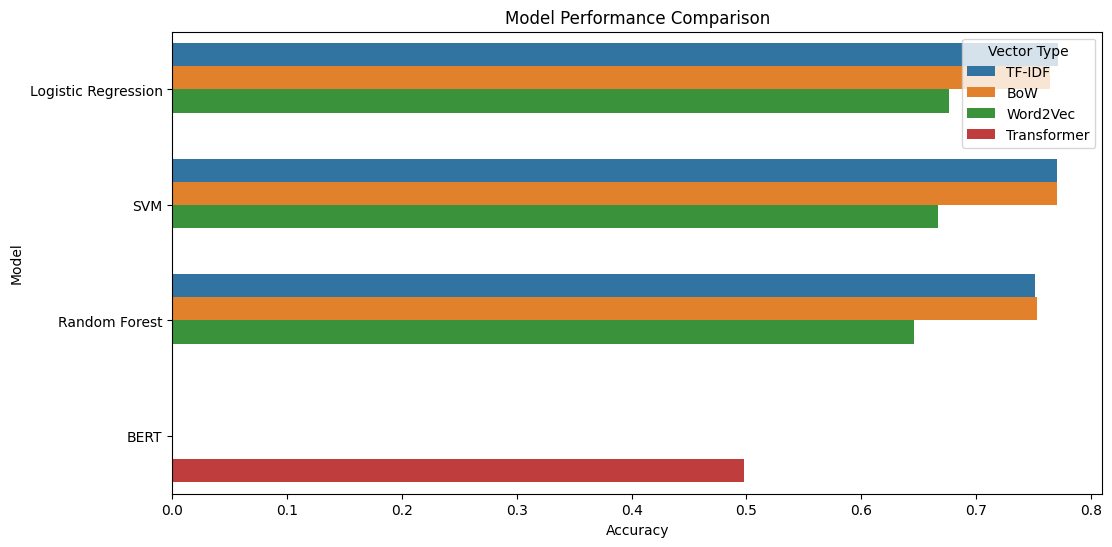

In [146]:
# Visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(x="Accuracy", y="Model", hue="Vector", data=results_df, orient='h')
plt.title("Model Performance Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.legend(title="Vector Type")
plt.show()

In [148]:
display(results_df)

,Model,Vector,Accuracy
3,Logistic Regression,TF-IDF,0.7713
4,SVM,TF-IDF,0.7708
1,SVM,BoW,0.7706
0,Logistic Regression,BoW,0.7644
2,Random Forest,BoW,0.7534
5,Random Forest,TF-IDF,0.7517
6,Logistic Regression,Word2Vec,0.6762
7,SVM,Word2Vec,0.6665
8,Random Forest,Word2Vec,0.6459
9,BERT,Transformer,0.4977


## Conclusion

### Best Performing Models
- **TF-IDF + Logistic Regression** (77.13%) and **TF-IDF + SVM** (77.08%) are the best models.
- **BoW + SVM** (77.06%) also performs well, making BoW features competitive.

### Key Observations
- **Random Forest** does not perform well with sparse representations (TF-IDF: 75.17%, BoW: 75.34%).
- **Word2Vec models** show the weakest performance (Logistic Regression: 67.62%, Random Forest: 64.59%).
- **BERT's performance is poor (50%)**, likely due to being trained for only 1 epoch, as my system is not powerful enough for longer training.

### Recommendation
- **TF-IDF + SVM** or **Logistic Regression** are recommended for the best results.
- If using **BERT**, longer training and a more powerful system are needed to improve performance.


In [156]:
df_sample.to_csv('Sampled_data.csv')